**Background**  
In this notebook we compare the influence of size and compositions of the panels.

## Composition test

In [ ]:
from collections import defaultdict

from bearclaw.feature_extraction import (
    _get_cosmic_feature_names as get_cosmic_feature_names,
    _COSMIC_MUTATIONAL_SIGNATURES,
)
import pandas as pd
from pandas import read_csv
import scipy as sp
from statkit.views import format_p_value

In [ ]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

from src.extrapolate import deconvolute_spectra, signature_fnr

To test for bias, we compare the mutation spectrum from whole genome sequencing with those from the panel.
If the allocation of mutations to the channels differs from whole genome sequencing, than there is a panel bias.

In [ ]:
channels = get_cosmic_feature_names("single_base_substitutions", False)

# Hartwig discovery whole genoming sequencing dataset, containing non-synonymous only.
exome_size = 47.9  # Only needed for WGS.
X_ref = read_csv("../artifacts/hartwig_wes_spectrum.tsv", sep="\t", index_col=0)[channels] * exome_size
# In silico projection of `X` onto the TSO500 panel.
X_tso500 = read_csv(
    "../artifacts/hartwig_in_silico_tso500_spectrum.tsv", sep="\t", index_col=0
)[channels]
X_f1cdx = read_csv(
    "../artifacts/hartwig_in_silico_foundation_one_cdx_spectrum.tsv",
    sep="\t",
    index_col=0,
)[channels]
X_msk468 = read_csv(
    "../artifacts/hartwig_in_silico_msk_468_spectrum.tsv", sep="\t", index_col=0
)[channels]
X_msk341 = read_csv(
    "../artifacts/hartwig_in_silico_msk_341_spectrum.tsv", sep="\t", index_col=0
)[channels]
X_msk410 = read_csv(
    "../artifacts/hartwig_in_silico_msk_410_spectrum.tsv", sep="\t", index_col=0
)[channels]
X_pancan = read_csv(
    "../artifacts/hartwig_in_silico_pan_cancer_spectrum.tsv", sep="\t", index_col=0
)[channels]

In [ ]:
n_channels = X_ref.sum(axis=0)
p_wgs = n_channels / n_channels.sum()
n_tso500_channels = X_tso500.sum(axis=0)
n_f1cdx_channels = X_f1cdx.sum(axis=0)
n_msk468 = X_msk468.sum(axis=0)
n_pancan = X_pancan.sum(axis=0)

In [ ]:
f_exp = p_wgs * n_tso500_channels.sum()
res = sp.stats.chisquare(n_tso500_channels, f_exp)
print(
    "TSO500 is not significantly different:",
    format_p_value(res.pvalue, format="compact").replace("$", ""),
)

TSO500 is not significantly different: 0.24


In [ ]:
f_exp = p_wgs * n_f1cdx_channels.sum()
res = sp.stats.chisquare(n_f1cdx_channels, f_exp)
print(
    "F1 CDx is not significantly different:",
    format_p_value(res.pvalue, format="compact").replace("$", ""),
)

F1 CDx is not significantly different: 0.40


In [ ]:
f_exp = p_wgs * n_msk468.sum()
res = sp.stats.chisquare(n_msk468, f_exp)
print(
    "MSK impact is not significantly different:",
    format_p_value(res.pvalue, format="compact").replace("$", ""),
)

MSK impact is not significantly different: 0.16


In [ ]:
f_exp = p_wgs * n_pancan.sum()
res = sp.stats.chisquare(n_pancan, f_exp)
print(
    "Pan cancer is significantly different:",
    format_p_value(res.pvalue, format="compact").replace("$", ""),
)

Pan cancer is significantly different: 1.8 \cdot 10^{-12}


## Effect of panel size: Coarse graining analysis
The following analyses, we extrapolate existing panels to hypothetical similar composition but larger size. 
We do this by coarse graining over patients with a similar signature attributions. To determine which patients have a similar signature attribution, we cluster the patients using k-means.

In [1]:
!mkdir -p figs/fnr/
import pickle
from typing import Any 

import pandas as pd

from matplotlib import pyplot as plt
import numpy as np
from pandas import read_csv
import scipy as sp
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from statkit.types import Estimate

In [2]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

from src.extrapolate import deconvolute_spectra, extrapolate_fnr
from src.utils import entropic_centre_of_mass, kendall_tau_correlation, normalise_columns

In [3]:
from bearclaw.feature_extraction import (
    _COSMIC_MUTATIONAL_SIGNATURES,
    _get_cosmic_feature_names as get_cosmic_feature_names,
)

In [4]:
# Compute entropies of mutational signatures.
H = pd.read_csv(
    _COSMIC_MUTATIONAL_SIGNATURES["single_base_substitutions"], sep="\t", index_col=0
).transpose()

s_sbs = pd.Series(sp.stats.entropy(H, axis=1), index=H.index)

In [5]:
# How many times to replicate the samples (or equivalently, how many times to enlarge the panel size).
channels = get_cosmic_feature_names("single_base_substitutions", False)

# Hartwig discovery whole genoming sequencing dataset, containing non-synonymous only.
exome_size = 47.9  # Only needed for WGS.
X = read_csv("../artifacts/hartwig_wes_spectrum.tsv", sep="\t", index_col=0)[channels]* exome_size
# In silico projection of `X` onto the TSO500 panel.
X_tso500 = read_csv(
    "../artifacts/hartwig_in_silico_tso500_spectrum.tsv", sep="\t", index_col=0
)[channels]
X_f1cdx = read_csv(
    "../artifacts/hartwig_in_silico_foundation_one_cdx_spectrum.tsv",
    sep="\t",
    index_col=0,
)[channels]
X_msk468 = read_csv(
    "../artifacts/hartwig_in_silico_msk_468_spectrum.tsv", sep="\t", index_col=0
)[channels]
X_pancan = read_csv(
    "../artifacts/hartwig_in_silico_pan_cancer_spectrum.tsv", sep="\t", index_col=0
)[channels]


In [6]:
# Cluster the patients before coarse graining.
Xs = (X, X_tso500, X_f1cdx, X_msk468, X_pancan)
Ws = deconvolute_spectra(*Xs, drop_artefacts=False)

To determine the number of cluster, we use the elbow method.

Text(0, 0.5, 'Score')

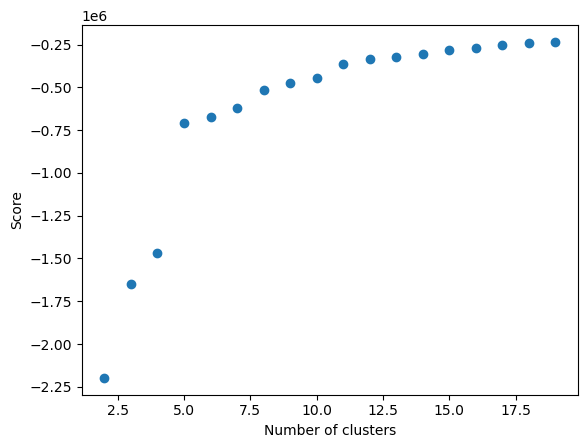

In [7]:
W_ref = Ws[0]
Ks = range(2, 20)
km = [KMeans(n_clusters=i,  n_init='auto', random_state=42) for i in Ks]
score = [km[i].fit(W_ref).score(W_ref) for i in range(len(km))]
plt.plot(Ks, score, 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

Based on this curve, we think the elbow is located around k=7 clusters.
Next, we assign the clusters to the patients.

<AxesSubplot:>

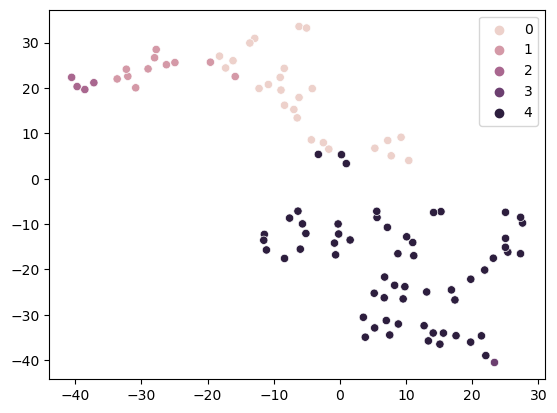

In [8]:
h_embed = TSNE(perplexity=5., random_state=42).fit_transform(W_ref)

y_cluster = KMeans(n_clusters=5, n_init='auto').fit_predict(W_ref)

sns.scatterplot(x=h_embed[:, 0], y=h_embed[:, 1], hue=y_cluster)


Determine the reliability of the panels by computing the coefficient of variation for different signatures.

In [9]:
def coefficient_of_variation(*data: pd.DataFrame) -> pd.Series:
    return [df.std(axis=0) / df.mean(axis=0) for df in data]

W_cvs = coefficient_of_variation(*Ws)
print(f'WGS CV(SBS4)', W_cvs[0]['SBS4'], 'WGS CV(SBS87)', W_cvs[0]['SBS87'])
print(f'TSO500 CV(SBS4)', W_cvs[1]['SBS4'], 'TSO500 CV(SBS87)', W_cvs[1]['SBS87'])
print(f'F1 CDX CV(SBS4)', W_cvs[2]['SBS4'], 'F1 CDX CV(SBS87)', W_cvs[2]['SBS87'])
print(f'MSK-IMPACT CV(SBS4)', W_cvs[3]['SBS4'], 'MSK-IMPACT CV(SBS87)', W_cvs[3]['SBS87'])
print(f'Pan Cancer CV(SBS4)', W_cvs[4]['SBS4'], 'Pan Cancer CV(SBS87)', W_cvs[4]['SBS87'])

WGS CV(SBS4) 1.4276114484749984 WGS CV(SBS87) 1.040940270340764
TSO500 CV(SBS4) 2.5775262728339974 TSO500 CV(SBS87) 2.1986576868158707
F1 CDX CV(SBS4) 3.024342528149724 F1 CDX CV(SBS87) 2.51631215801934
MSK-IMPACT CV(SBS4) 2.45298119317596 MSK-IMPACT CV(SBS87) 2.0890674056048453
Pan Cancer CV(SBS4) 1.7291299088512873 Pan Cancer CV(SBS87) 1.8688022539594455


In [10]:
name_idx = ('WGS', 'TSO500', 'F1 CDx', 'MSK-IMPACT (468)', 'Pan Cancer')
Ss = entropic_centre_of_mass(*Ws)
for s, name in zip(Ss, name_idx):
    print(name, f'Information gain: {s.mean():.2f} +/- {s.std():.2f} nats')


WGS Information gain: 3.18 +/- 0.32 nats
TSO500 Information gain: 2.93 +/- 0.30 nats
F1 CDx Information gain: 2.93 +/- 0.43 nats
MSK-IMPACT (468) Information gain: 2.96 +/- 0.34 nats
Pan Cancer Information gain: 3.11 +/- 0.30 nats


### The actual extrapolation calculation is done here.

In [11]:
kwargs = {
    'stratify':y_cluster, 
    'n_iterations': 100,
}
tso500_estimates = extrapolate_fnr(X, X_tso500, n_max=10, **kwargs)

..........


In [12]:
f1cdx_estimates = extrapolate_fnr(X, X_f1cdx, n_max=10, **kwargs)
msk468_estimates = extrapolate_fnr(X, X_msk468, n_max=10, **kwargs)
pancan_estimates = extrapolate_fnr(X, X_pancan, n_max=6, **kwargs)

..........
..........
......


In [13]:
def get_x_y(estimates: dict[Any, Estimate], column):
    """Turn a dictionary of estimates into x, y, yerr for plotting."""
    x = []
    y = []
    yerr = []
    for n, fnr_estimate in estimates.items():
        col_idx = fnr_estimate.point.index.get_loc(column)
        x.append(n)
        y_n = fnr_estimate.point.iloc[col_idx]
        y.append(y_n)
        yerr.append([y_n - fnr_estimate.lower[col_idx], fnr_estimate.upper[col_idx] - y_n])

    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr).transpose()

    return x, y, yerr

In [14]:
# Length of the panels in Megabases (Mb).
length_tso500 = 1.272_967
length_f1cdx = 1.335_884
length_msk468 = 1.848_194
length_pancan = 3.999_266
lengths = {
    'TSO500': length_tso500,
    'F1 CDx': length_f1cdx,
    'MSK-IMPACT (468)': length_msk468,
    'Pan Cancer': length_pancan,
}

In [15]:
exome_size = 47.9
p_detect = length_tso500 / exome_size

def p_false_negative(x, p_hit: float = p_detect):
    """Probability of a false negative.
    
    Args:
        x: Number of mutations.
        p_hit: Probability of detecting a mutation.
    """
    # Probability of no detection.
    p_miss = 1 - p_hit
    return x.apply(lambda n: p_miss**n).mean()

In [16]:
def theory_false_negative_rate(x_panel_size, n_attributed: pd.DataFrame) -> pd.DataFrame:
    """Estimate FNR for given mutational signature attributions and panel size."""
    exome_size = 47.9
    
    signature_names = n_attributed.columns
    fnrs = pd.DataFrame(0.0, columns=signature_names, index=x_panel_size)
    for signature in signature_names:
        for l in x_panel_size:
            p_hit = l / exome_size   
            n_attr = n_pos[signature].dropna()
            fnrs.loc[l, signature] = p_false_negative(n_attr, p_hit)
    return fnrs

# Estimate theoretically the number of false negatives.
# 1) Compute number signature attributed substitutions from WGS.
X_sign = deconvolute_spectra(X)[0]

n_signature = np.ceil(X_sign).astype(int)
n_pos = n_signature[n_signature > 0]
SBS_columns = X_sign.columns
# 2) Evaluate predictions upto 20 Mb.
x_panel_size = np.linspace(0, 20, 100)  # Size of panel in Megabases.
fnrs = theory_false_negative_rate(x_panel_size, n_signature)

In [17]:
def plot_fnr(xy_theory, tso500_estimates, f1cdx_estimates, msk468_estimates, pancan_estimates, signature_name):
    f = plt.figure(figsize=(5,3))

    x_theory, fnr_theory = xy_theory
    x_tso500, y_tso500, yerr_tso500 = get_x_y(tso500_estimates, signature_name)
    plt.errorbar([length_tso500], y_tso500[:1], yerr=yerr_tso500[:, :1], fmt='o', color='tab:blue',  label='TSO500')
    plt.errorbar(x_tso500[1:] * length_tso500, y_tso500[1:], yerr=yerr_tso500[:, 1:], fmt='o', color='tab:blue', fillstyle='none', label='TSO500 sim.')

    x_f1cdx, y_f1cdx, yerr_f1cdx = get_x_y(f1cdx_estimates, signature_name)
    plt.errorbar([length_f1cdx], y_f1cdx[:1], yerr=yerr_f1cdx[:,:1], fmt='s', color='tab:orange',  label='F1 CDx')
    plt.errorbar(x_f1cdx[1:]*length_f1cdx, y_f1cdx[1:], yerr=yerr_f1cdx[:, 1:], fmt='s', color='tab:orange', fillstyle='none', label='F1 CDx sim.')

    x_msk468, y_msk468, yerr_msk468 = get_x_y(msk468_estimates, signature_name)
    plt.errorbar([length_msk468], y_msk468[:1], yerr=yerr_msk468[:, :1], fmt='^', color='tab:green',  label='MSK-IMPACT (468)')
    plt.errorbar(x_msk468[1:]*length_msk468, y_msk468[1:], yerr=yerr_msk468[:, 1:], fmt='^', color='tab:green', fillstyle='none', label='MSK-IMPACT (468) sim.')

    x_pancan, y_pancan, yerr_pancan = get_x_y(pancan_estimates, signature_name)
    plt.errorbar([length_pancan], y_pancan[:1], yerr=yerr_pancan[:,:1], fmt='v', color='tab:purple',  label='Pan Cancer')
    plt.errorbar(x_pancan[1:5]*length_pancan, y_pancan[1:5], yerr=yerr_pancan[:,1:5], fmt='v', color='tab:purple', fillstyle='none', label='Pan Cancer sim.')

    plt.plot(x_theory, fnr_theory[signature_name], '-', label='Theory', color='tab:red')


    plt.ylim(0.0-0.05, 1.05)
    plt.xlim(0.0-plt.xlim()[1]*0.05, plt.xlim()[1])
    plt.xlabel('Panel size (Mb)')
    plt.ylabel(f'False negative rate\n{signature_name}')
    plt.legend(frameon=False, loc='upper right', prop={'size': 7}, ncol=2)
    plt.tight_layout()
    return f

In [18]:
# To rule out false positives mutational signatures, we impose the following
# selection criteria for signatures:
# 1) Since we coarse grain over up to 10 subjects, re require > 10 positive whole genome
# attributions.
atleast_10_positives = n_signature.sum(axis=0) > 10
# 2) On average, the signature accounts for atleast 3 % of the mutations.
# We choose this number because the reconstruction error is estimated to be 2.9 %. See
# notebook 6_false_negative_theory_experiment_msimatch.ipynb
relative_attributions = X_sign / X_sign.sum(axis=1).to_numpy().reshape(-1, 1)
enough_attrs = relative_attributions.mean(axis=0) >= 0.03

signature_selection = atleast_10_positives & enough_attrs
sbs_selected = signature_selection.index[signature_selection]
print(f'In total, we analysed m={len(sbs_selected)} mutational signatures:')
print(sbs_selected)

In total, we analysed m=9 mutational signatures:
Index(['SBS1', 'SBS2', 'SBS4', 'SBS13', 'SBS15', 'SBS24', 'SBS35', 'SBS39',
       'SBS87'],
      dtype='object')


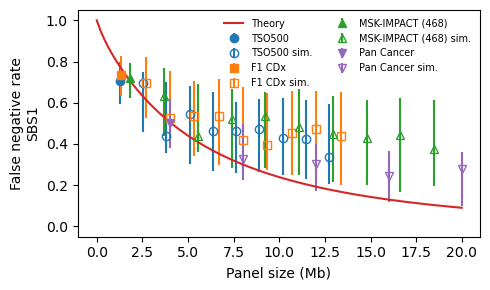

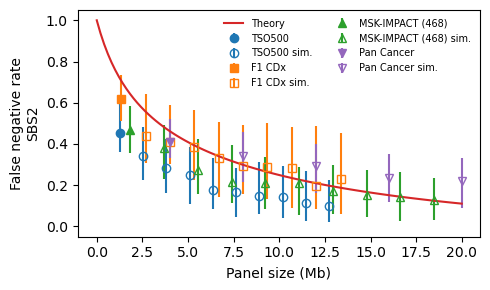

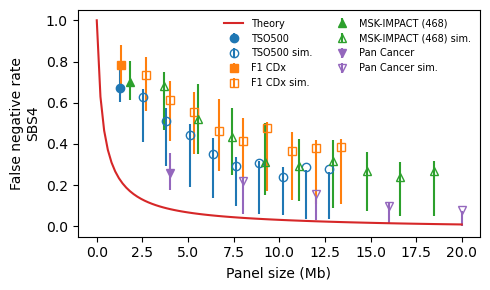

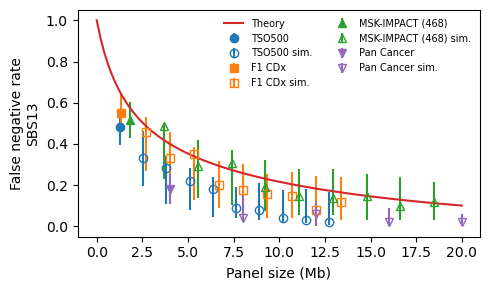

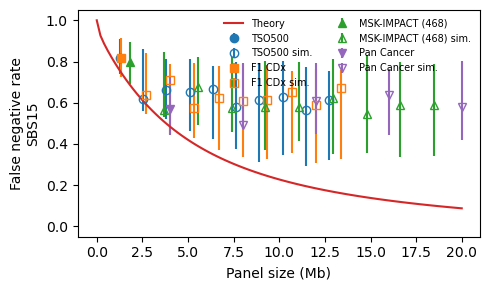

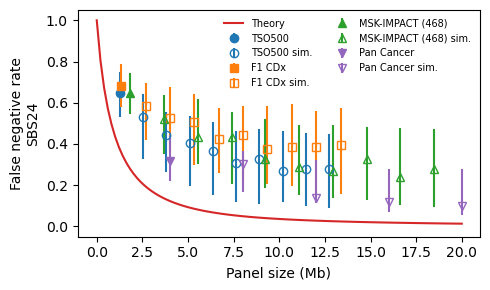

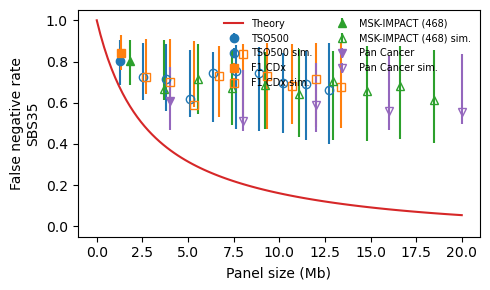

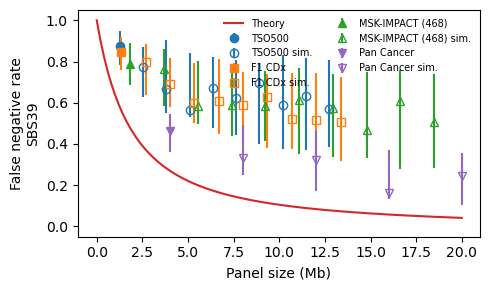

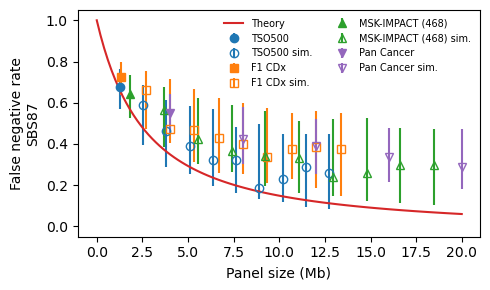

In [19]:
for name in n_pos.loc[:, signature_selection].dropna(axis=1, how='all').columns:
    f = plot_fnr(
        (x_panel_size, fnrs),
        tso500_estimates,
        f1cdx_estimates,
        msk468_estimates,
        pancan_estimates,
        signature_name=name,
    )
    f.savefig(f'figs/fnr/{name}.png', bbox_inches='tight')
    f.savefig(f'figs/fnr/{name}.pdf', bbox_inches='tight')
    f.savefig(f'figs/fnr/{name}.svg', bbox_inches='tight')
    f.savefig(f'figs/fnr/{name}.eps', bbox_inches='tight')

In [22]:
# Pickle the estimates dicts to disk.
with open('../artifacts/pickle/hartwig_in_silico_tso500_estimates.pkl', 'wb') as f:
    pickle.dump(tso500_estimates, f)
with open('../artifacts/pickle/hartwig_in_silico_f1cdx_estimates.pkl', 'wb') as f:
    pickle.dump(f1cdx_estimates, f)
with open('../artifacts/pickle/hartwig_in_silico_msk468_estimates.pkl', 'wb') as f:
    pickle.dump(msk468_estimates, f)
with open('../artifacts/pickle/hartwig_in_silico_pan_cancer_estimates.pkl', 'wb') as f:
    pickle.dump(pancan_estimates, f)

In [23]:
# # Load pickles from disk to avoid recomputation.
# with open('../artifacts/pickle/hartwig_in_silico_tso500_estimates.pkl', 'rb') as f:
#     tso500_estimates = pickle.load(f)
# with open('../artifacts/pickle/hartwig_in_silico_f1cdx_estimates.pkl', 'rb') as f:
#     f1cdx_estimates = pickle.load(f)
# with open('../artifacts/pickle/hartwig_in_silico_msk468_estimates.pkl', 'rb') as f:
#     msk468_estimates = pickle.load(f)
# with open('../artifacts/pickle/hartwig_in_silico_pan_cancer_estimates.pkl', 'rb') as f:
#     pancan_estimates = pickle.load(f)

## Perturpbation experiment
Signatures such as SBS15, SBS35, and SBS39 have a very large false negative rate. We want to better understand that.
Here, we perturb the mutation spectrum channel-by-channel with one mutationm and see which channel leads to the largest FNR reduction.

In [ ]:
Xs = (X_ref, X_tso500, X_f1cdx, X_msk468, X_pancan)
Ws = deconvolute_spectra(*Xs, drop_artefacts=False)
(W_ref, W_tso500, W_f1cdx, W_msk468, W_pancan) = Ws
signatures = get_cosmic_feature_names("single_base_substitutions", True)

In [ ]:
perturbation = pd.DataFrame(index=channels, columns=get_cosmic_feature_names("single_base_substitutions", signatures=True))

for c in channels:
    # Perturb both matrices with one mutation.
    X_pert_true = X_ref.copy()
    X_pert_pred = X_tso500.copy()
    X_pert_true.loc[:, c] += 1
    X_pert_pred.loc[:, c] += 1
    print(f'Perturbing {c}')
    Ws_pert = deconvolute_spectra(X_pert_true, X_pert_pred, drop_artefacts=False)
    delta_w = signature_fnr(*Ws_pert) - signature_fnr(W_ref, W_tso500)
    perturbation.loc[c] = delta_w

Perturbing A[C>A]A
Perturbing A[C>A]C
Perturbing A[C>A]G
Perturbing A[C>A]T
Perturbing A[C>G]A
Perturbing A[C>G]C
Perturbing A[C>G]G
Perturbing A[C>G]T
Perturbing A[C>T]A
Perturbing A[C>T]C
Perturbing A[C>T]G
Perturbing A[C>T]T
Perturbing A[T>A]A
Perturbing A[T>A]C
Perturbing A[T>A]G
Perturbing A[T>A]T
Perturbing A[T>C]A
Perturbing A[T>C]C
Perturbing A[T>C]G
Perturbing A[T>C]T
Perturbing A[T>G]A
Perturbing A[T>G]C
Perturbing A[T>G]G
Perturbing A[T>G]T
Perturbing C[C>A]A
Perturbing C[C>A]C
Perturbing C[C>A]G
Perturbing C[C>A]T
Perturbing C[C>G]A
Perturbing C[C>G]C
Perturbing C[C>G]G
Perturbing C[C>G]T
Perturbing C[C>T]A
Perturbing C[C>T]C
Perturbing C[C>T]G
Perturbing C[C>T]T
Perturbing C[T>A]A
Perturbing C[T>A]C
Perturbing C[T>A]G
Perturbing C[T>A]T
Perturbing C[T>C]A
Perturbing C[T>C]C
Perturbing C[T>C]G
Perturbing C[T>C]T
Perturbing C[T>G]A
Perturbing C[T>G]C
Perturbing C[T>G]G
Perturbing C[T>G]T
Perturbing G[C>A]A
Perturbing G[C>A]C
Perturbing G[C>A]G
Perturbing G[C>A]T
Perturbing G

In [ ]:
# The following signatures were analysed in notebook 5_b.
columns_to_test = [
    "SBS1",
    "SBS2",
    "SBS4",
    "SBS13",
    "SBS15",
    "SBS24",
    "SBS35",
    "SBS39",
    "SBS87",
]
for signature_name in columns_to_test:
    top_channel = perturbation[signature_name].astype(float).idxmin()
    print(signature_name, '=>', top_channel, perturbation.loc[top_channel, signature_name])

SBS1 => A[C>T]G -0.6817859673990079
SBS2 => T[C>T]A -0.42879898056705956
SBS4 => C[C>A]C -0.29460950008895215
SBS13 => T[C>G]A -0.48314606741573035
SBS15 => G[C>T]G -0.7836990595611286
SBS24 => G[C>A]C -0.6171150278293135
SBS35 => C[T>A]T -0.5781151170145478
SBS39 => A[C>G]A -0.5783676417479233
SBS87 => C[C>T]G -0.6465819721718088


# Relation FNR with specific channels
In the previous section we saw that, for TSO500, the FNR was specifically sensitive to mutations in:
- `G[C>T]G` (SBS15)
- `C[T>A]T` (SBS35)
- `A[C>G]A` (SBS39)

Are these significantly depleted?

More specifically, those samples that are a FN, are they more likely to have a spectrum negative?

In [ ]:
def to_contigency_matrix(x_true: pd.Series, x_pred: pd.Series) -> pd.DataFrame:
    """Turn predicted and true values into a contigency matrix."""
    return pd.crosstab(x_true, x_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
test_channel_vs_signature = pd.DataFrame(0.0, columns=['channel', 'statistic', 'm', 'n_w_negative', 'n_c_negative & n_w_negative', 'p_value'], index=columns_to_test)

is_p = W_ref[signatures] > 0
for signature_name in columns_to_test:
    is_sbs_fn = W_tso500[is_p[signature_name]][signature_name] == 0
    top_channel = perturbation[signature_name].astype(float).idxmin()
    is_x_p = X_tso500[is_p[signature_name]][top_channel] == 0
    cm_sbs = to_contigency_matrix(is_sbs_fn, is_x_p)
    print(signature_name)
    print(cm_sbs)

    res = sp.stats.fisher_exact(cm_sbs.to_numpy()[:2, :2])
    p_value_pretty = format_p_value(res.pvalue, format='compact').replace('$', '')
    test_channel_vs_signature.loc[signature_name, 'channel'] = top_channel
    test_channel_vs_signature.loc[signature_name, 'statistic'] = res.statistic
    test_channel_vs_signature.loc[signature_name, 'p_value'] = p_value_pretty
    # Number of samples whole-genome wide positive for signature.
    test_channel_vs_signature.loc[signature_name, 'm'] = len(is_sbs_fn)
    # Number of samples signature negative in silico panel.
    test_channel_vs_signature.loc[signature_name, 'n_w_negative'] = sum(is_sbs_fn)
    # Number of samples signature negative in silico and singlet channel negative.
    test_channel_vs_signature.loc[signature_name, 'n_c_negative & n_w_negative'] = cm_sbs.to_numpy()[1, 1]

    print('p =', p_value_pretty)
    print('------------------------')


SBS1
Predicted  False  True  All
True                       
False         15     5   20
True           1    47   48
All           16    52   68
p = 5.1 \cdot 10^{-10}
------------------------
SBS2
Predicted  False  True  All
True                       
False         31     9   40
True           1    32   33
All           32    41   73
p = 1.9 \cdot 10^{-11}
------------------------
SBS4
Predicted  False  True  All
True                       
False         21     3   24
True          10    39   49
All           31    42   73
p = 7.4 \cdot 10^{-8}
------------------------
SBS13
Predicted  False  True  All
True                       
False         27    19   46
True           0    43   43
All           27    62   89
p = 9.2 \cdot 10^{-11}
------------------------
SBS15
Predicted  False  True  All
True                       
False          8     0    8
True           0    36   36
All            8    36   44
p = 5.6 \cdot 10^{-9}
------------------------
SBS24
Predicted  False  True  All
T

## Enrichment analysis
The smoking signature SBS4 is surprisingly depleted. There may be two reasons: either 
1. SBS4 is misattributed with so little mutations
2. Smoke mutations are actually depleted.

To check if this due to 1., we look at `G>T` <=> `C>A` mutations, that are related to smoke-like aromatic compounds [1], and compare whole genome with the panel.

[1]: Nik-Zainal et al. The genome as a record of environmental exposure, mutagenesis 30, 763  ('15).  

In [ ]:
from src.feature_extraction import COSMIC_MUTATIONAL_SIGNATURES, get_feature_names

substitution_names = get_feature_names('single_base_substitutions', signatures=False)

# Make a dict with key point mutation and item list of flanking contexts.
# E.g., 'C>A': ['A[C>A]A', ...]
point_mutations = defaultdict(list)
for name in substitution_names:
    key = name[2:5]
    point_mutations[key].append(name)

In [ ]:
# Absolute enrichment of mutations in silico versus WGS per Mb.
n_panels = {
    'TSO500': pd.DataFrame(index=X_tso500.index, columns=point_mutations.keys()),
    'F1 CDx': pd.DataFrame(index=X_f1cdx.index, columns=point_mutations.keys()),
    'MSK-IMPACT (468)': pd.DataFrame(index=X_msk468.index, columns=point_mutations.keys()),
    'Pan Cancer': pd.DataFrame(index=X_pancan.index, columns=point_mutations.keys()),
}
n_wgs = pd.DataFrame(index=X.index, columns=point_mutations.keys())

# Aggregate mutations by substitution.
for point, point_context in point_mutations.items():
    n_panels['TSO500'].loc[:, point] = X_tso500[point_context].sum(axis=1) / length_tso500
    n_panels['F1 CDx'].loc[:, point] = X_f1cdx[point_context].sum(axis=1) / length_f1cdx
    n_panels['MSK-IMPACT (468)'].loc[:, point] = X_msk468[point_context].sum(axis=1) / length_msk468
    n_panels['Pan Cancer'].loc[:, point] = X_pancan[point_context].sum(axis=1) / length_pancan
    n_wgs.loc[:, point] = X[point_context].sum(axis=1)

In [ ]:
enrichment_absolute={}
for panel_name, n_i in n_panels.items():

    r_abs = np.divide(
        n_i.to_numpy(dtype=float),
        n_wgs.to_numpy(dtype=float),
        where=n_wgs.to_numpy(dtype=float) != 0,
        out=np.ones_like(n_wgs.values),
    )
    enrichment_absolute[panel_name] = pd.DataFrame(
        r_abs, columns=n_i.columns, index=n_i.index
    )

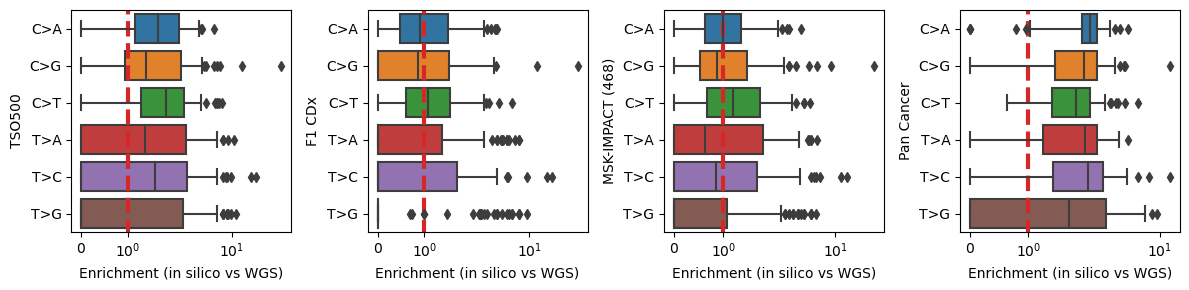

In [ ]:
%matplotlib inline

f, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
for i, name in enumerate(enrichment_absolute.keys()):
    ax = axes[i]
    ax.set_xscale("symlog")
    # ax.set_xlim([0.0001, 1.1])
    ax.set_ylim([-0.5, 5.5])
    ax.set_xlabel('Enrichment (in silico vs WGS)')
    ax.set_ylabel(name)
    r_marginal = enrichment_absolute[name]
    ax.plot(np.ones(6), np.arange(6)*2 - 3, '--', linewidth=3.0, color='tab:red')
    sns.boxplot(data=r_marginal, orient='h', ax=ax)

plt.tight_layout()
f.savefig('figs/fig_s5a_point_mutation_absolute_enrichments.pdf', bbox_inches='tight')
f.savefig('figs/fig_s5a_point_mutation_absolute_enrichments.png', bbox_inches='tight')
f.savefig('figs/fig_s5a_point_mutation_absolute_enrichments.svg', bbox_inches='tight')
f.savefig('figs/fig_s5a_point_mutation_absolute_enrichments.eps', bbox_inches='tight')